In [43]:
# only run once and the restart the kernel 
from numba import cuda
devices = cuda.get_current_device()
devices.reset()

In [1]:
import time
import os
import gc 
import h5py
import json

import numpy as np
from tqdm import tqdm
from tkinter import Tcl

import matplotlib.pyplot as plt 

from scipy import ndimage
from PIL import Image

from sklearn.utils import shuffle

from preProcessingUtils import *

### Data Reading 

In [2]:
root_dir = 'D:\sagar\Data'
scans = os.listdir(root_dir)

In [3]:
path_roi = []
path_notRoi = []

for s in scans:
    scan_path = os.path.join(root_dir, s)
    try:
        for r in os.listdir(os.path.join(scan_path, 'roi')):
            path_roi.append((os.path.join(root_dir, s, 'roi', r)))
    except:
        pass
    try:    
        for nr in os.listdir(os.path.join(scan_path, 'not_roi')):
            path_notRoi.append((os.path.join(root_dir, s, 'not_roi', nr)))
    except: 
        pass
   

print('Found ', len(path_roi), ' ROI and ', len(path_notRoi), ' notROI sample')  

Found  532  ROI and  561  notROI sample


In [4]:
# From the classified samples 
root_dir2 = 'E:\sagar\Data'
scans2 = os.listdir(root_dir2)

In [5]:
path_TP = []
path_FN = []

path_FP = []

for s in scans2:
    scan_path = os.path.join(root_dir2, s)
    try:
        for r in os.listdir(os.path.join(scan_path, 'TP')):
            path_TP.append((os.path.join(root_dir2, s, 'TP', r)))
    except:
        pass
    
    try:
        for r in os.listdir(os.path.join(scan_path, 'FN')):
            path_FN.append((os.path.join(root_dir2, s, 'FN', r)))
    except:
        pass
    
    try:    
        for nr in os.listdir(os.path.join(scan_path, 'FP')):
            path_FP.append((os.path.join(root_dir2, s, 'FP', nr)))
    except: 
        pass
   

print('Found ', len(path_TP)+len(path_FN), ' ROI and ', len(path_FP), ' notROI sample')  

Found  144  ROI and  326  notROI sample


In [ ]:
# Shuffleing and choosing the sample for test and train 
path_roi = shuffle(path_roi, random_state=32)
path_notRoi = shuffle(path_notRoi, random_state=32)

In [ ]:
tmp_roi_path, test_roi_path = path_roi[0:600], path_roi[600:676]
tmp_notRoi_path, test_notRoi_path = path_notRoi[0:600], path_notRoi[800:887]

In [6]:
# combining the both data set 
path_roi = path_roi + path_TP + path_FN
path_notRoi = path_notRoi + path_FP

In [7]:
print('Number of ROI ', len(path_roi), '\n Number of Not ROI ', len(path_notRoi))

Number of ROI  676 
 Number of Not ROI  887


In [10]:
# 15% split for the validation data
train_roi_path, val_roi_path = tmp_roi_path[0:500], tmp_roi_path[500:600]
train_notRoi_path, val_notRoi_path = tmp_notRoi_path[0:500], tmp_notRoi_path[500:600]

In [11]:
def create_formatted_data(dataPath, xdim=300, ydim=300, zdim=300, resize_factor=(0.5, 0.5, 0.5)):
    
    print('Loading ', len(dataPath), ' Samples.... ')
    
    formattedData = np.zeros(shape=(len(dataPath), int(xdim*resize_factor[0]), int(ydim*resize_factor[1]), int(zdim*resize_factor[2]), 1), dtype=np.bool_)

    for i, afile in enumerate(tqdm(dataPath)):
        raw_vol = []
        #sorting the slices according to their names like in windows 
        slices = Tcl().call('lsort', '-dict', os.listdir(afile))
        for aSlice in slices:
            img = Image.open(os.path.join(afile, aSlice))
            imgarray = np.array(img)
            raw_vol.append(imgarray)

        raw_vol = np.asarray(raw_vol)
        raw_vol = np.nan_to_num(raw_vol)
        raw_vol = np.clip(raw_vol, 0.0005, 0.003)
        raw_vol = ndimage.zoom(raw_vol, resize_factor, order=1)
        # Normalize the data : 0-1
        vol = norm8bit(raw_vol)
        th_vol = vol < 55
        formattedData[i, :, :, :, 0] = th_vol 
    
    print('Loaded ', len(dataPath), ' Samples with shape ', formattedData.shape, '\n')
    return formattedData

In [12]:
train_roi = create_formatted_data(train_roi_path)
val_roi = create_formatted_data(val_roi_path)
test_roi = create_formatted_data(test_roi_path)


train_notRoi = create_formatted_data(train_notRoi_path)
val_notRoi = create_formatted_data(val_notRoi_path)
test_notRoi = create_formatted_data(test_notRoi_path)

Loading  500  Samples.... 


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [21:51<00:00,  2.62s/it]


Loaded  500  Samples with shape  (500, 150, 150, 150, 1) 

Loading  100  Samples.... 


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:21<00:00,  2.62s/it]


Loaded  100  Samples with shape  (100, 150, 150, 150, 1) 

Loading  76  Samples.... 


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [03:22<00:00,  2.67s/it]


Loaded  76  Samples with shape  (76, 150, 150, 150, 1) 

Loading  500  Samples.... 


 95%|███████████████████████████████████████████████████████████████████████████▊    | 474/500 [20:46<01:08,  2.64s/it]D:\sagar\roiClassifier\preProcessingUtils.py:84: RuntimeWarning: invalid value encountered in true_divide
  v = ((v - minVal)/maxVal) * 255
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [21:54<00:00,  2.63s/it]


Loaded  500  Samples with shape  (500, 150, 150, 150, 1) 

Loading  100  Samples.... 


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:20<00:00,  2.61s/it]


Loaded  100  Samples with shape  (100, 150, 150, 150, 1) 

Loading  87  Samples.... 


100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [03:48<00:00,  2.62s/it]

Loaded  87  Samples with shape  (87, 150, 150, 150, 1) 



In [13]:
# Creating the label 
train_roi_label = []
for i in range(len(train_roi_path)):
    train_roi_label.append([1, 0])

train_roi_label = np.array(train_roi_label)


# Creating the label 
val_roi_label = []
for i in range(len(val_roi_path)):
    val_roi_label.append([1, 0])

val_roi_label = np.array(val_roi_label)

# Creating the label 
test_roi_label = []
for i in range(len(test_roi_path)):
    test_roi_label.append([1, 0])

test_roi_label = np.array(test_roi_label)


# Creating the label 
train_notRoi_label = []
for i in range(len(train_notRoi_path)):
    train_notRoi_label.append([0, 1])

train_notRoi_label = np.array(train_notRoi_label)

# Creating the label 
val_notRoi_label = []
for i in range(len(val_notRoi_path)):
    val_notRoi_label.append([0, 1])

val_notRoi_label = np.array(val_notRoi_label)


# Creating the label 
test_notRoi_label = []
for i in range(len(test_notRoi_path)):
    test_notRoi_label.append([0, 1])

test_notRoi_label = np.array(test_notRoi_label)

In [40]:
# Saving the data to the drive
hf = h5py.File('D:\\sagar\\roiClassifier\\trainData\\TrainValTest_Data_150_150_150_Clip_Norm8bit_th55_bool2.hdf5', 'w')
hf.create_dataset('roi', data=train_roi, compression='gzip')
hf.create_dataset('notRoi', data=train_notRoi, compression='gzip')
hf.create_dataset('val_roi', data=val_roi, compression='gzip')
hf.create_dataset('val_notRoi', data=val_notRoi, compression='gzip')
hf.create_dataset('test_roi', data=test_roi, compression='gzip')
hf.create_dataset('test_notRoi', data=test_notRoi, compression='gzip')
hf.close()

In [41]:
#Saving 
hf = h5py.File('D:\\sagar\\roiClassifier\\trainData\\TrainValTest_Label_150_150_150_Clip_Norm8bit_th55_bool2.hdf5', 'w')
hf.create_dataset('roi', data=train_roi_label, compression='gzip')
hf.create_dataset('notRoi', data=train_notRoi_label, compression='gzip')
hf.create_dataset('val_roi', data=val_roi_label, compression='gzip')
hf.create_dataset('val_notRoi', data=val_notRoi_label, compression='gzip')
hf.create_dataset('test_roi', data=test_roi_label, compression='gzip')
hf.create_dataset('test_notRoi', data=test_notRoi_label, compression='gzip')
hf.close()

In [2]:
# Reading the train data 
hf = h5py.File('D:\\sagar\\roiClassifier\\trainData\\TrainValTest_Data_150_150_150_Clip_Norm8bit_th55_bool2.hdf5', 'r')
hf.keys
train_roi = np.array(hf.get('roi'))
train_notRoi = np.array(hf.get('notRoi'))
val_roi = np.array(hf.get('val_roi'))
val_notRoi = np.array(hf.get('val_notRoi'))
test_roi = np.array(hf.get('test_roi'))
test_notRoi = np.array(hf.get('test_notRoi'))



In [3]:
# Reading the train data 
hf = h5py.File('D:\\sagar\\roiClassifier\\trainData\\TrainValTest_Label_150_150_150_Clip_Norm8bit_th55_bool2.hdf5', 'r')
hf.keys
train_roi_label = np.array(hf.get('roi'))
train_notRoi_label = np.array(hf.get('notRoi'))
val_roi_label = np.array(hf.get('val_roi'))
val_notRoi_label = np.array(hf.get('val_notRoi'))
test_roi_label = np.array(hf.get('test_roi'))
test_notRoi_label = np.array(hf.get('test_notRoi'))


### Data Augmentation 

In [4]:
# Data Augmentation : 8 Set Possible
# 1. Original Data 
# 2,3,4,5 Rotate 45, 90, 180 
# 6, 7, 8 Flip 

# 

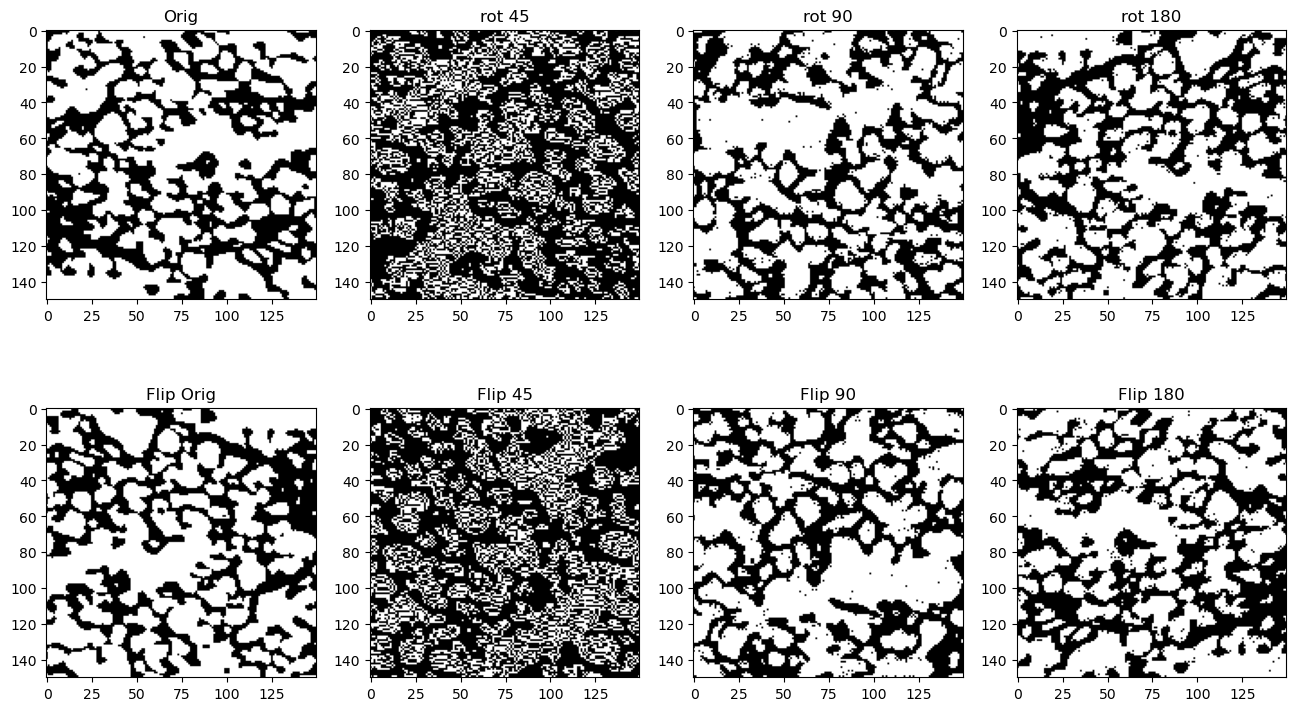

In [14]:
aVol = train_roi[0, :, :, :, 0]
fig, ax = plt.subplots(2,4, figsize=(16,9))
ax[0,0].imshow(aVol[75, :, :,], cmap='gray')
ax[0,0].set_title('Orig')

rot45 = ndimage.rotate(aVol, 45, reshape=False)
ax[0,1].imshow(rot45[75, :, :], cmap='gray')
ax[0,1].set_title('rot 45')

rot90 = ndimage.rotate(aVol, 90, reshape=False)
ax[0,2].imshow(rot90[75, :, :], cmap='gray')
ax[0,2].set_title('rot 90')

rot180 = ndimage.rotate(aVol, 180, reshape=False)
ax[0,3].imshow(rot180[75, :, :], cmap='gray')
ax[0,3].set_title('rot 180')

###########

flip = np.flip(aVol)
ax[1,0].imshow(flip[75, :, :], cmap='gray')
ax[1,0].set_title('Flip Orig')


flip45 = np.flip(rot45)
ax[1,1].imshow(flip45[75, :, :], cmap='gray')
ax[1,1].set_title('Flip 45')

flip90 = np.flip(rot90)
ax[1,2].imshow(flip90[75, :, :], cmap='gray')
ax[1,2].set_title('Flip 90')

flip180 = np.flip(rot180)
ax[1,3].imshow(flip180[75, :, :], cmap='gray')
ax[1,3].set_title('Flip 180')

plt.show()

plt.close()

In [15]:
# Rotate formatted volume 
def rotateFormattedVol(arr, angle, reshape=False):
    result = np.empty_like(arr)
    for i in range(arr.shape[0]):
        vol = arr[i, :, :, :, 0]
        vol = ndimage.rotate(vol, angle, reshape=reshape)
        vol[ vol < 0] = 0
        vol[ vol > 1] = 1
        result[i, :, :, :, 0] = vol 
        
    return result


# Flip formatted volume 
def flipFormattedVol(arr):
    result = np.empty_like(arr)
    for i in range(arr.shape[0]):
        vol = arr[i, :, :, :, 0]
        vol = np.flip(vol)
        result[i, :, :, :, 0] = vol 
    
    return result

In [16]:
trainDataROI = np.concatenate( (train_roi, flipFormattedVol(train_roi),  
                                rotateFormattedVol(train_roi, 90), flipFormattedVol(rotateFormattedVol(train_roi, 90)), 
                                rotateFormattedVol(train_roi, 180), flipFormattedVol(rotateFormattedVol(train_roi, 180))),
                                axis=0)

train_label_ROI = np.concatenate((train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label), axis=0)

In [17]:
del train_roi
del train_roi_label

In [18]:
gc.collect()

104

In [19]:
trainDatanotROI = np.concatenate( (train_notRoi, flipFormattedVol(train_notRoi),  
                                rotateFormattedVol(train_notRoi, 90), flipFormattedVol(rotateFormattedVol(train_notRoi, 90)), 
                                rotateFormattedVol(train_notRoi, 180), flipFormattedVol(rotateFormattedVol(train_notRoi, 180))),
                                axis=0)

train_label_notROI = np.concatenate((train_notRoi_label, train_notRoi_label,
                                  train_notRoi_label, train_notRoi_label,
                                  train_notRoi_label, train_notRoi_label), axis=0)

In [20]:
del train_notRoi
del train_notRoi_label

In [21]:
gc.collect()

63

### Training Data preparation 

In [22]:
# trainFeatures = np.concatenate((train_roi, train_notRoi), axis=0)
# valFeatures = np.concatenate((val_roi, val_notRoi), axis=0)

trainFeatures = np.concatenate((trainDataROI, trainDatanotROI), axis=0)
valFeatures = np.concatenate((val_roi, val_notRoi), axis=0)

In [23]:
# del train_roi
# del train_notRoi

del trainDataROI
del trainDatanotROI

del val_roi
del val_notRoi



In [24]:
gc.collect()

63

In [25]:
# trainLabels = np.concatenate((train_roi_label, train_notRoi_label), axis=0)
# valLabels = np.concatenate((val_roi_label, val_notRoi_label), axis=0)

trainLabels = np.concatenate((train_label_ROI, train_label_notROI), axis=0)
valLabels = np.concatenate((val_roi_label, val_notRoi_label), axis=0)

In [26]:
# del train_roi_label
# del train_notRoi_label

del train_label_ROI
del train_label_notROI

del val_roi_label
del val_notRoi_label



In [27]:
gc.collect()

63

In [28]:
trainFeatures.shape

(6000, 150, 150, 150, 1)

In [29]:
trainFeatures.dtype

dtype('bool')

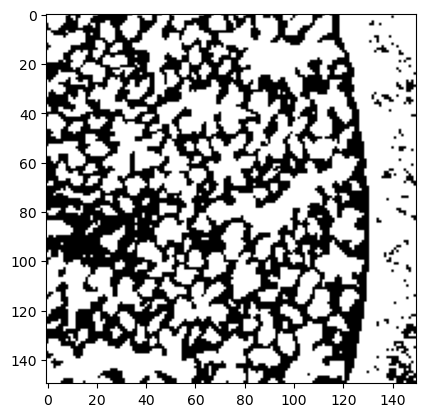

In [30]:
plt.imshow(trainFeatures[200, 75, :, :, 0], cmap='gray')

In [31]:
from sklearn.utils import shuffle

In [32]:
X_train, y_train = shuffle(trainFeatures, trainLabels, random_state=2)
X_val, y_val = shuffle(valFeatures, valLabels, random_state=2)

In [33]:
del trainFeatures
del trainLabels
del valFeatures
del valLabels
gc.collect()

63

In [34]:
whos

Variable                Type        Data/Info
---------------------------------------------
Image                   module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
Tcl                     function    <function Tcl at 0x000001C80178C1F8>
X_train                 ndarray     6000x150x150x150x1: 20250000000 elems, type `bool`, 20250000000 bytes (19311.904907226562 Mb)
X_val                   ndarray     200x150x150x150x1: 675000000 elems, type `bool`, 675000000 bytes (643.7301635742188 Mb)
aVol                    ndarray     150x150x150: 3375000 elems, type `bool`, 3375000 bytes (3.2186508178710938 Mb)
ax                      ndarray     2x4: 8 elems, type `object`, 64 bytes
create_formatted_data   function    <function create_formatte<...>ta at 0x000001C8070CBB88>
ctypes                  module      <module 'ctypes' from 'C:<...>ib\\ctypes\\__init__.py'>
fig                     Figure      Figure(1600x900)
flip                    ndarray     150x150x150: 3375000 elems,

In [35]:
y_val[:10]

array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0]])

In [36]:
import tensorflow as tf 
print(tf.__version__)

1.15.0


In [37]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam

In [38]:
#del model 
#gc.collect()

In [39]:
#gpus = tf.config.experimental.list_physical_devices('GPU')

In [40]:
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [41]:
# Building a model 
input_shape=X_train.shape[1:]
model = models.Sequential()
# Conv Layers 
model.add(layers.Conv3D(8, (3, 3, 3), padding='same', activation ='relu', input_shape=input_shape, data_format='channels_last'))
model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv3D(16, (3, 3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling3D(pool_size=(3,3,3)))
model.add(layers.BatchNormalization())


# FC layer 
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(rate = 0.1))

model.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dropout(rate = 0.1))
model.add(layers.Dense(2, activation='softmax', kernel_regularizer='l2'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 150, 150, 150, 8)  224       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 75, 75, 75, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 75, 8)     32        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 75, 75, 75, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 37, 37, 37, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 37, 16)    64        
_________________________________________

In [42]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

timeNow = time.strftime('%m%d%H%M')

csvFile = 'logs/train_150_clip_norm8bit_bool_Aug_ang90_180_flip_' + timeNow + '.csv'
csv_logger = CSVLogger(csvFile, append=True, separator=';')


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.001)

# saves model after every epoch or only best model yet if 'save_best_only=True'
model_checkpoint = ModelCheckpoint(('models/best_model2_' + timeNow + '.hdf5'), monitor='val_loss', verbose=1, save_best_only=True, mode='min')


def print_summary(s):
    txt_file = csvFile.replace('.csv', '.txt')
    with open(txt_file,'a') as f:
        print(s, file=f)

model.summary(print_fn=print_summary)

# Training the model 
epochs = 50
batch_size = 16
hist = model.fit(X_train, y_train, batch_size=batch_size,
                 epochs=epochs, verbose=1, callbacks=[csv_logger, early_stopping, model_checkpoint],
                 validation_data=(X_val, y_val))

Train on 6000 samples, validate on 200 samples
Epoch 1/50


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv3d/Conv3D}}]]
	 [[loss/add/_247]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv3d/Conv3D}}]]
0 successful operations.
0 derived errors ignored.

In [30]:
gc.collect()

35

In [31]:
modelName = 'models/CNNSecondPass_' + timeNow + '.hdf5' 
model.save(modelName)

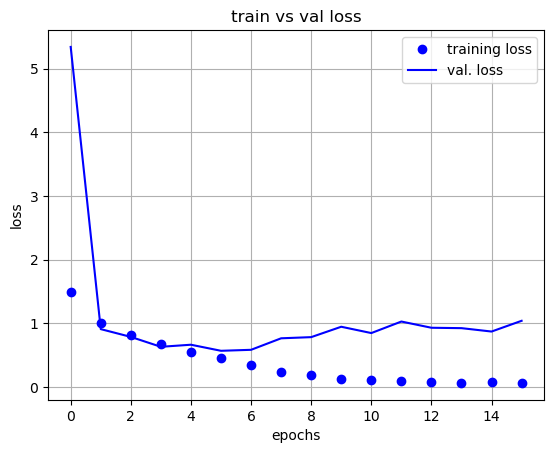

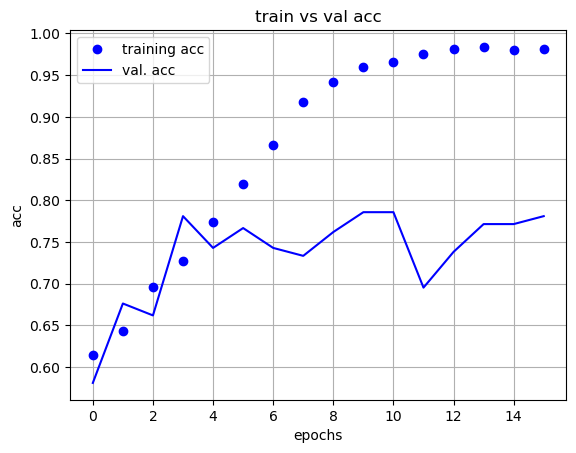

In [33]:
# Display trainig statistics 
loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['acc']
val_acc = hist.history['val_acc']

epochsr = range(16)

plt.figure()
plt.plot(epochsr, loss, 'bo', label='training loss')
plt.plot(epochsr, val_loss, 'b', label='val. loss')
plt.title('train vs val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid('ON')
plt.show()


plt.figure()
plt.plot(epochsr, acc, 'bo', label='training acc')
plt.plot(epochsr, val_acc, 'b', label='val. acc')
plt.title('train vs val acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.grid('ON')
plt.show()

In [4]:
from tensorflow.keras.models import load_model

In [5]:
modelName = 'CNNSecondPass_10251109.hdf5'
modelPath = 'models/'+ modelName

model = load_model(modelPath)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# Model evaluation 
X_test = np.concatenate((test_roi, test_notRoi), axis=0)
y_test = np.concatenate((test_roi_label, test_notRoi_label), axis=0)

In [8]:
scores = model.evaluate(X_test, y_test)
print('Test %s: %.2f%%' % (model.metrics_names[1], scores[1]*100))

163/163 [==============================] - 6s 34ms/sample - loss: 1.2962 - acc: 0.7301
Test acc: 73.01%


In [9]:
modelName = 'best_model2_10251109.hdf5'
modelPath = 'models/'+ modelName

model = load_model(modelPath)

In [10]:
scores = model.evaluate(X_test, y_test)
print('Test %s: %.2f%%' % (model.metrics_names[1], scores[1]*100))

163/163 [==============================] - 3s 20ms/sample - loss: 0.5709 - acc: 0.7055
Test acc: 70.55%
